In [13]:
# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries
import re
import math
import string
import nltk
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
import matplotlib.pyplot as plt

# Getting particular functions from these libraries 
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}') #<< faster than doing api.load
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = True
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = False
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('DEV:', text)  #<< 4/12/24 changed "VERBOSE" to "DEV"
    return

showCellCompletion = True  #<< 4/12/24 set default to True
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = True
accelerator = True

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

SyntaxError: invalid syntax (1153365197.py, line 9)

In [2]:
## Only run once
#>> Seems to need to be rerun after every Kaggle timeout.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
# Load data from CSV
#>>  3/13 needed to change the path as below
# path ='/kaggle/input/Reviews.csv'#"/kaggle/input/amazon-product-reviews/Reviews.csv"
data = pd.read_csv(reviews_file) # Use pandas to analyze data
showD('Amazon reviews loaded into Panda')

DEV: Amazon reviews loaded into Panda


In [4]:
# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                     

In [5]:
# Check for empty entries or missing data in each column
for column in data.columns:
    if data[column].isnull().values.any():
        print(f"Column '{column}' has empty entries or missing data.")
    else:
        print(f"Column '{column}' has no empty entries or missing data.")

Column 'Id' has no empty entries or missing data.
Column 'ProductId' has no empty entries or missing data.
Column 'UserId' has no empty entries or missing data.
Column 'ProfileName' has empty entries or missing data.
Column 'HelpfulnessNumerator' has no empty entries or missing data.
Column 'HelpfulnessDenominator' has no empty entries or missing data.
Column 'Score' has no empty entries or missing data.
Column 'Time' has no empty entries or missing data.
Column 'Summary' has empty entries or missing data.
Column 'Text' has no empty entries or missing data.


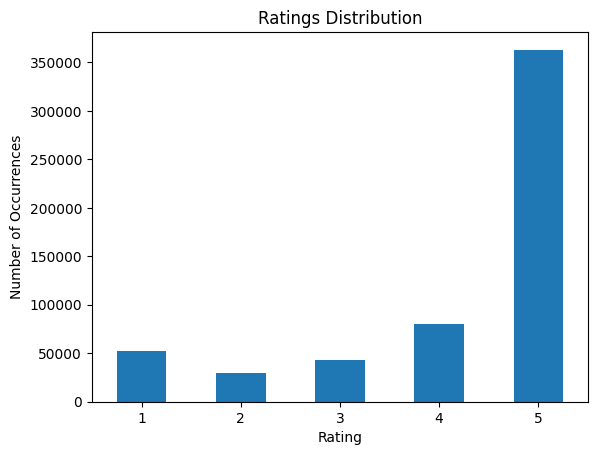

In [6]:
# Get count of ratings 
rating_counts = data['Score'].value_counts()

# Sort counts by index ascending
rating_counts = rating_counts.sort_index()  

# Create bar plot
ax = rating_counts.plot(kind = 'bar')

ax.set_title("Ratings Distribution")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Occurrences")

# Fix x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0) 

for rating, count in rating_counts.items():
        printd(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show() #<< show the rating in each of the 5 categories

In [7]:
balanced_data_size = 2000 #4/12 spacy tokenizer hanging ...10000 #25000<< number of reviews in each rating category, tailored for CPU capacity
# Specify the column for sorting and balancing
sort_column = 'Score'  # This is one the rating column

# Sort the data by the rating values
sorted_data = data.sort_values(by = sort_column)

# Create a balanced dataset with 25,000 samples from each class
#balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n=25000))

#>> DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 
#>> This behavior is deprecated, and in a future version of pandas the grouping 
#>> columns will be excluded from the operation. 
#>> Either pass `include_groups=False` to exclude the groupings or 
#>> explicitly select the grouping columns after groupby to silence this warning.
#
balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))

#>> Does this mean to reset the row numbers?? ##Columns Numbers
balanced_data.reset_index(drop = True, inplace = True)

printv(f"The number of reviews equally distributed across all ratings is {len(balanced_data['Score'])}")

VERBOSE: The number of reviews equally distributed across all ratings is 10000


/tmp/ipykernel_34/1593203213.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))


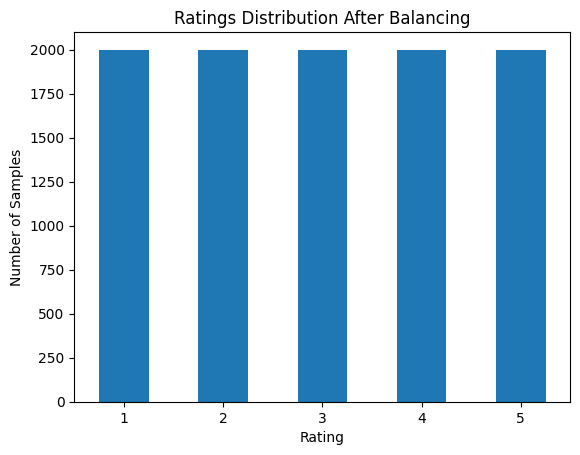

In [8]:
# Get count of ratings
rating_counts = balanced_data['Score'].value_counts()

# Create bar plot
ax = rating_counts.plot(kind='bar')

ax.set_title("Ratings Distribution After Balancing")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Samples")

# Fix x-axis ticks  
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

# Print number of reviews per rating

if DEV:
    for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show()

In [9]:
# 4/18 nltk stop words, without negatives like "don't"
custom_stop_words =['a', 'about', 'above', 'after',  'all', 'am', 'an', 'and', 'any',
'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
'between', 'both', 'but', 'by', 'can',  'd', 'did',
 'do', 'does', 'doing', 'down',
'during', 'each', 'for', 'from', 'further', 'had', 'has',  'have', 'having',
'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how',
'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its',
'itself', 'just', 'll', 'm', 'ma', 'me',  'more',
'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't",
'nor',  'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's',
'same',  'she', "she's", 'so', 'some', 'such', 't', 'than', 'that',
"that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too',
'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we',
'were',  'what', 'when', 'where', 'which', 'while',
'who', 'whom', 'why', 'will', 'with', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your',
'yours', 'yourself', 'yourselves']


In [11]:
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.0 MB/s eta 0:00:0000:01
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=50428 sha256=def68c11259cefc2caff6823da7a0a43996e4f27215005c6786f186b550955ff
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [15]:
import pkg_resources
from symspellpy import SymSpell
import spacy
# Load the English tokenizer model from spaCy
nlp = spacy.load("en_core_web_lg")

# Compile the regular expressions for cleaning text
html_tags = re.compile("<.*?>")
punct_and_symbols = re.compile(r'[^\w\s\']+')

# Initialize and load SymSpell dictionary for word segmentation
sym_spell = SymSpell(max_dictionary_edit_distance = 0, prefix_length = 7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index = 0, count_index = 1)

def tokenizer(text, nlp, sym_spell, custom_stop_words):
    """
    Tokenizes a text string, segments run-on words, and removes stop words.
    
    text (str): The text string to tokenize.
    nlp: The spaCy language model.
    sym_spell: The SymSpell object for correcting run-on words.
    custom_stop_words (list): A list of custom stop words to remove.

    Returns:
        list: The tokenized text string.
    """
    # Clean text
    text = text.lower()  # Convert text to lowercase
    text = html_tags.sub("", text)  # Remove HTML tags
    # text = punct_and_symbols.sub("", text)  # Replace punctuation and symbols with space
    text = punct_and_symbols.sub(" ", text)  # Replace punctuation and symbols with space

    # Segment text using SymSpell
    segmented = sym_spell.word_segmentation(text)
    clean_text = segmented.corrected_string
    
    # Tokenize the text using spaCy
    doc = nlp(clean_text)

    # Remove stop words and punctuation tokens
    tokens = [token.text for token in doc if not token.is_punct 
              and token.text not in custom_stop_words] 

    return tokens

# Assuming 'balanced_data' is a pandas DataFrame with a column 'Text'
# Apply the tokenizer function to the 'Text' column
balanced_data['CleanedReview'] = balanced_data['Text'].apply(lambda x: tokenizer(x, nlp, sym_spell, custom_stop_words))

# Indicate completion
print('Tokenizer defined, and CleanedReview column created')

Tokenizer defined, and CleanedReview column created


In [ ]:
'''
import spacy
import re
import pandas as pd

from transformers import BertTokenizer, BertModel

showD('Loading spacy ...')
# Load the English tokenizer model
nlp = spacy.load("en_core_web_sm")
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Compile the regular expressions
html_tags = re.compile("<.*?>")
punct_and_symbols = re.compile(r'[^\w\s\']+')
numeric = re.compile(r'\d+')
def tokenizer(text, nlp):
    """
    Tokenizes a text string and removes stop words.
    
    text (str): The text string to tokenize.
    nlp: The Spacy language model.

    Returns:
        list: The tokenized text string.
    """
    text = text.lower()  # Convert text to lowercase
    text = html_tags.sub("", text)  # Remove HTML tags
    text = punct_and_symbols.sub("", text)  # Remove punctuation and symbols

    # Tokenize the text
    
    doc = nlp(text)

    # Remove punctuation tokens
    #
    #>> To do: improve tokenization to eliminate stop words like "and"; separate
    #>> concatenated tokens like "carcinogensmouthwashes"; correct misspelling like "pugnent"
    tokens = [token.text for token in doc if not token.is_punct and not token.text in stop_words
             and not re.fullmatch(numeric,token.text)]# 

    return tokens

# Assuming balanced_data is a pandas DataFrame and 'Text' is a column containing the reviews
# Apply the function to the Text column and store it in a new column
showD('Applying tokenizer ...')

#>> 4/12/24 takes 4 minutes to process 1K reviews!
balanced_data['CleanedReview'] = balanced_data['Text'].apply(lambda x: tokenizer(x, nlp))
# Show that cell has finished executing
showC(f'{tokenizer} defined, and then used to create CleanedReview column')
'''

In [16]:
# Store the Rating column
rating = balanced_data['Score']  

# Store the CleanedReview column
tokenized_review = balanced_data['CleanedReview']

#>> 4/12/24 tried to make output more descriptive
printv(f'Looking into product reviews')

printv(f"First balanced data review: {balanced_data['Text'][0]}")
printv(f"First balanced data tokenized review: {tokenized_review[0]}")
printv(f"First balanced data tokenized review length: {len(tokenized_review[0])}")
printv(f"tokenized_review shape: {tokenized_review.shape}")

VERBOSE: Looking into product reviews
VERBOSE: First balanced data review: This tea seemed like a good deal, it turned out not! The tea leaves were a combination of brown, black, and crispy. There was absolutely no green to it at all. I would never buy Davidson's again.
VERBOSE: First balanced data tokenized review: ['tea', 'seemed', 'like', 'good', 'deal', ' ', 'turned', 'not', ' ', 'tea', 'leaves', 'combination', 'brown', ' ', 'black', ' ', 'crispy', ' ', 'absolutely', 'no', 'green', ' ', 'would', 'never', 'buy', 'davidson', "'s", 'again']
VERBOSE: First balanced data tokenized review length: 28
VERBOSE: tokenized_review shape: (10000,)


Mean: 56.46
Median: 40.00
Mode: ModeResult(mode=18, count=231)


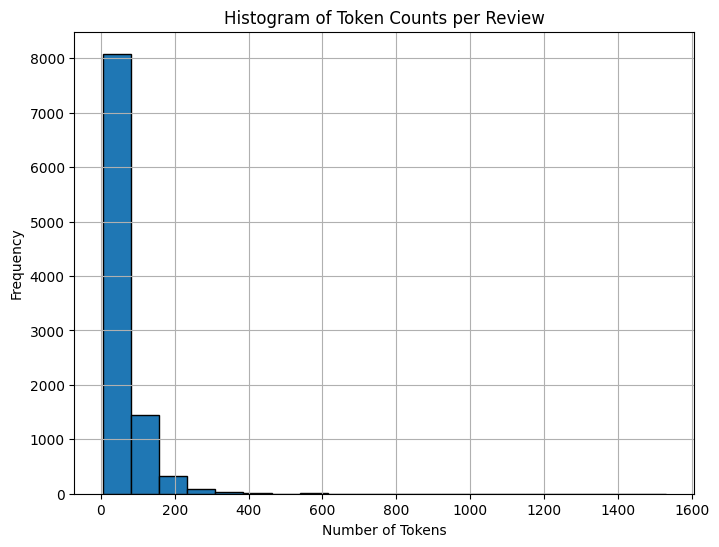

In [17]:
from scipy import stats

def analyze_review_tokens(reviews):
    token_counts = [len(review) for review in reviews]

    mean = np.mean(token_counts)
    median = np.median(token_counts)
    mode = stats.mode(token_counts)

    print(f"Mean: {mean:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Mode: {mode}")

    plt.figure(figsize=(8, 6))
    plt.hist(token_counts, bins=20, edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Histogram of Token Counts per Review')
    plt.grid(True)
    plt.show()

analyze_review_tokens(tokenized_review)

In [18]:
# >> 3/29/24 Took less than a minute to run without the accelerator.
# Load Word2Vec model
#w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load_word2vec_format (w2v_file, binary=True)

# Define the aimum sequence length (adjust as needed)
#>> Will increasing max_sequence_length impact performance?
max_sequence_length = 100

showD(f'{w2v} can map words onto vectors with 300 dimensions')
#if 'diet' in w2v: print('diet is in')

DEV: KeyedVectors<vector_size=300, 3000000 keys> can map words onto vectors with 300 dimensions


In [19]:
# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")
    accelerator = True

else:
    accelerator = False
    print("CUDA is not available.")
    device = torch.device("cpu")
    print(device)

CUDA is available!
GPU 0: Tesla P100-PCIE-16GB


In [20]:
#>> Create word embeddings
# Assume you have a list of tokenized review called tokenized_review
# Each element in tokenized_review is a list of tokens for a single review

lengths = []
for review_tokens in tokenized_review:
    lengths.append(len(review_tokens))

lengths = sorted(lengths)
lengths = lengths[-1:0:-1]
showD(f'Lengths of 100 longest reviews: {lengths[0:100]}')        

max_sequence_length = 200 #<< 4/13/24 1347 was the longest review length in sample

# Initialize an empty tensor for padded reviews on the GPU
padded_reviews = torch.zeros((len(tokenized_review), max_sequence_length, 300))

# Initialize a mask tensor of the same shape as padded_reviews
# Set it to False (or 0) initially, representing that all positions are padding
# mask = torch.zeros_like(padded_reviews, dtype=torch.bool)

# Initialize a mask tensor of the same shape as padded_reviews but with only sequence length
mask = torch.zeros((len(tokenized_review), max_sequence_length), dtype=torch.bool)

out_words = {}
words_in = 0
words_out = 0

# Now, during the padding and embedding conversion loop, update the mask as well
for i, review_tokens in enumerate(tokenized_review):
    review_length = min(len(review_tokens), max_sequence_length)
    for j in range(review_length):
        word = review_tokens[j]
        if word in w2v:
            words_in += 1
            # Use Word2Vec vector if available
            padded_reviews[i, j, :] = torch.tensor(w2v[word])
            mask[i, j] = True  # Update the mask to indicate the presence of a word
        else:
            words_out += 1
            out_words[word] = out_words.get(word, 0) + 1
        # Otherwise, the mask remains False (or 0) for padding

# Now you have a mask tensor that you can use later in your processing to ignore padded values
# For example, if you want to apply max pooling only on non-padded values, you could use:
# review_embeddings = torch.max(padded_reviews * mask.unsqueeze(-1).float(), dim=1)[0]

# Ensure the mask is treated as a float for any operations that require it
mask = mask.float()

# Now you can use this mask tensor to exclude the padding from any subsequent computations

printv(f'{words_in} words found with vector representations, {words_out} without')
printv(f'Number of unique words without vector representations: {len(out_words)}')
printv('Sample of words without vector representations')
kwords = list(out_words.keys())
for idx in range(0,len(kwords)-1,25):
    kword = kwords[idx]
    printv(f'{kword} - {out_words[kword]}')
# Apply max pooling to aggregate embeddings along the sequence dimension
# review_embeddings = torch.max(padded_reviews, dim=1)[0]

# Now,review_embeddings contains the aggregated Word2Vec 
# embeddings for each review on the GPU

showC(f"Created zero-padded, standard length reviews")

DEV: Lengths of 100 longest reviews: [1530, 747, 726, 672, 598, 572, 563, 556, 556, 556, 556, 556, 556, 556, 556, 556, 556, 555, 552, 545, 540, 530, 502, 457, 449, 441, 434, 434, 427, 416, 413, 384, 377, 372, 361, 360, 358, 355, 354, 351, 351, 349, 347, 344, 342, 340, 340, 338, 334, 329, 328, 323, 323, 322, 321, 313, 313, 310, 310, 309, 309, 307, 307, 303, 303, 301, 300, 299, 296, 296, 295, 294, 294, 290, 290, 287, 287, 282, 281, 281, 279, 279, 277, 277, 277, 275, 275, 275, 273, 273, 273, 272, 272, 272, 272, 271, 270, 270, 270, 270]
VERBOSE: 443435 words found with vector representations, 98380 without
VERBOSE: Number of unique words without vector representations: 1271
VERBOSE: Sample of words without vector representations
VERBOSE:   - 65773
VERBOSE: bort - 3
VERBOSE: keu - 241
VERBOSE: 37 - 5
VERBOSE: ibd - 1
VERBOSE: kellogg - 45
VERBOSE: ewg - 2
VERBOSE: leto - 1
VERBOSE: 750ml - 2
VERBOSE: 2013 - 10
VERBOSE: 72 - 10
VERBOSE: 787 - 1
VERBOSE: qfc - 1
VERBOSE: rients - 1
VERBOSE: d

In [21]:
print(padded_reviews[1])

tensor([[ 0.2021, -0.2539, -0.0354,  ..., -0.0918, -0.1416, -0.0806],
        [-0.2930, -0.2373,  0.0859,  ...,  0.3672,  0.1738, -0.1729],
        [-0.0175, -0.0359,  0.0305,  ..., -0.0181, -0.1455, -0.0170],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [22]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
#>> to get the standard lenth
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
rating_labels_tensors = torch.tensor(rating.values).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
print('\n\n\n\n\n\n\n\n\n\n')
if accelerator and showNv:
    print(torch.cuda.memory_summary())

Cell complete: <torch.utils.data.dataset.TensorDataset object at 0x7b3ed44019f0> defined
Total allocated memory: 2400080384 bytes
Sat Apr 20 02:20:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              34W / 250W |   2548MiB / 16384MiB |     40%      Default |
|                           

Dataset with missing reviews - done

Improved tokenizer - done

Mask 0-padded values in embedding tensor - done 

Max sequence of 1300. Max length of 500?

Encoder dropout to 0

Review token histogram for sequence length - done 

In [23]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
#>> to get the standard lenth
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
rating_labels_tensors = torch.tensor(rating.values).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

Cell complete: <torch.utils.data.dataset.TensorDataset object at 0x7b3ed4464bb0> defined


In [24]:
print(text_embeddings_tensors.shape)
print(rating_labels_tensors.shape)
print(text_embeddings_tensors.device)
print(rating_labels_tensors.device)
print(dataset)

torch.Size([10000, 200, 300])
torch.Size([10000])
cuda:0
cuda:0


In [25]:
# Lengths 
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len

# Random split
train_data, val_data = random_split(dataset, [train_len, val_len])

printv(f"The amount of data we have to train with is {len(train_data)} reviews") 
printv(f"The amount of data we have to validate with is {len(val_data)} reviews")
#print(f"The amount of data we have to validate with is on {train_data.device}")
#print(f"The amount of data we have to validate with is on {val_data.device}")

# DataLoader for training data
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)  # Use shuffle for training

# DataLoader for validation data
val_loader = DataLoader(val_data, batch_size = 32, shuffle = False)  # No need to shuffle for validation

VERBOSE: The amount of data we have to train with is 8000 reviews
VERBOSE: The amount of data we have to validate with is 2000 reviews


In [26]:
# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of your word embeddings
seq_len = max_sequence_length #<< 4/13/24 100  # Maximum sequence length
dropout = 0.1  # Adjust the dropout if needed

eps     = 1e-6 # epsilon value to prevent the standard deviation from becoming zero
num_classes = 5  # Replace with your number of classes
epochs = 1000
learning_rate = 0.01
num_layers = 6

input_size = d_model  # Adjust this based on the output size of your feed-forward network
# input_size = len(train_data[0])  # Adjust based on your input size (should match the output size of your model)
showC('Hyperparameters defined')

Cell complete: Hyperparameters defined


In [27]:
class Classifier(nn.Module):
    def __init__(self, r_size,v_size, num_classes):
        # r_size is the number of tokens in a review, 100.
        # v_size is the number of values in an embedding vector, 300.
        super(Classifier, self).__init__()
        
        # The input to fc will be a 2D tensor with with n rows and
        # r_size * v_size columns, where n >= 1; and the output will be a 2D tensor
        # with n rows and num_classes columns.
        self.fc = nn.Linear(r_size * v_size, num_classes)

    def forward(self, x1):
        # Pass input through the linear layer
        return self.fc(x1)

# Create the classifier
classifier = Classifier(seq_len, d_model, num_classes + 1).to(device)

showC(f'{Classifier} defined')

Cell complete: <class '__main__.Classifier'> defined


In [28]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    Credit:
    https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            #printd(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                printv(f'Early stopping: counter={self.counter}; patience={self.patience}')
                self.early_stop = True
early_stopping = EarlyStopping(patience=48) #patience=30, min_delta=.01) 
showC(f'{EarlyStopping} object defined')

Cell complete: <class '__main__.EarlyStopping'> object defined


In [29]:
# Define Cross-Entropy loss
criterion = nn.CrossEntropyLoss() # nn.CategoricalCrossentropy() #nn.Softmax() 

# Define SGD optimizer
# Is Adam better?
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

DEV = True
# Training loop (adjust this to match your data and DataLoader)
losses = {} #<< track losses
for epoch in range(epochs):
    for inputs, targets in train_loader :  # Assuming you have a DataLoader
        # for batch_data in train_loader:  # Assuming you have a DataLoader
        # inputs, targets = batch_data  # Assuming your DataLoader provides input data and targets    
    
        #printd(f'inputs shape: {inputs.shape}')
        #printd(f'targets shape: {targets.shape}')
        #printd(f'targets: {targets}')

        optimizer.zero_grad()
    
        # keep nn.linear happy by combining the last two dimensions of inputs.
        inputs = torch.reshape(inputs, (inputs.size(0), -1)) # get current batch size
        #inputs = torch.reshape(inputs, (32,30000))
        
        #printd(f'Reshaped inputs: {inputs.shape}')
        
        outputs = classifier(inputs)
        #printd(f'outputs shape {outputs.shape}')
        
        # output is a 32 x 6 tensor of floats,
        # targets will be a 32 x 1 tensor of ints
        loss = criterion(outputs, targets)
        # print(f'loss.item: {loss.item()}')
        loss.backward(retain_graph=True)
        optimizer.step()
        
       
    
    losses[loss.item()] = epoch+1
    early_stopping(loss)    
    if early_stopping.early_stop:
       printv(f'Stopping early at epoch [{epoch+1}/{epochs}] Loss: {loss.item()}')
       break    
        
    if epoch % 50 == 0:
        printv(f'Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}')
    
 
if VERBOSE:
    printv(f'Last loss: Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}')
    smallest_losses = sorted(list(losses.keys()))
    printv('Smallest losses')
    for idx in range(10):
        l = smallest_losses[idx]
        printv(f'    Loss: {l}, epoch = {losses[l]}')
showC(f'training complete')

VERBOSE: Epoch [1/1000] Loss: 1.5562409162521362
VERBOSE: Epoch [51/1000] Loss: 0.3706590235233307
VERBOSE: Epoch [101/1000] Loss: 0.40823686122894287
VERBOSE: Epoch [151/1000] Loss: 0.18451443314552307
VERBOSE: Epoch [201/1000] Loss: 0.16957975924015045
VERBOSE: Epoch [251/1000] Loss: 0.16404826939105988
VERBOSE: Epoch [301/1000] Loss: 0.11657333374023438
VERBOSE: Epoch [351/1000] Loss: 0.10888050496578217
VERBOSE: Early stopping: counter=48; patience=48
VERBOSE: Stopping early at epoch [352/1000] Loss: 0.08058095723390579
VERBOSE: Last loss: Epoch [352/1000] Loss: 0.08058095723390579
VERBOSE: Smallest losses
VERBOSE:     Loss: 0.07247376441955566, epoch = 304
VERBOSE:     Loss: 0.07434949278831482, epoch = 320
VERBOSE:     Loss: 0.07502900063991547, epoch = 340
VERBOSE:     Loss: 0.07800360769033432, epoch = 335
VERBOSE:     Loss: 0.07853716611862183, epoch = 323
VERBOSE:     Loss: 0.080002561211586, epoch = 347
VERBOSE:     Loss: 0.08006515353918076, epoch = 336
VERBOSE:     Loss: 0

In [30]:
# Put model in evaluation mode
classifier.eval() 

# Tracking variables
predictions = []
actuals = []


# Evaluate on validation set
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.reshape(inputs.shape[0], -1)

        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.tolist())
        actuals.extend(targets.tolist())


# Print predicted and actual values for all samples
#>> print("Predicted | Actual")
#>>for pred, actual in zip(predictions, actuals):
#>>    pass #printd(f"{pred} | {actual}")

# Calculate validation accuracy
#>> 4/12/24 Maybe it would help to see how close we came in each category?
#>> For example, for category 5 predictions, show the actual results in each 
#>> category. And where's there's a large disrepancy, show  the reviews.
r_by_category = [0,0,0,0,0]
r = list('12345')

for idx in range(5):
    r[idx] = r_by_category[:]
       
for p,a in zip(predictions, actuals):
    r[p-1][a-1] += 1 # Record the actual results for each category prediction

num_correct = 0
for idx in range (5):
    printv(f'Categrory {idx+1} predictions actual results: ' +\
           f'1. {r[idx][0]}; 2. {r[idx][1]}; 3. {r[idx][2]}; 4. {r[idx][3]}; 5. {r[idx][4]}')
    num_correct += r[idx][idx]
# num_correct = sum([p == a for p, a in zip(predictions, actuals)]) 
val_accuracy = num_correct / len(predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

VERBOSE: Categrory 1 predictions actual results: 1. 186; 2. 88; 3. 43; 4. 34; 5. 25
VERBOSE: Categrory 2 predictions actual results: 1. 114; 2. 117; 3. 75; 4. 58; 5. 45
VERBOSE: Categrory 3 predictions actual results: 1. 51; 2. 98; 3. 137; 4. 75; 5. 48
VERBOSE: Categrory 4 predictions actual results: 1. 26; 2. 61; 3. 71; 4. 145; 5. 90
VERBOSE: Categrory 5 predictions actual results: 1. 19; 2. 33; 3. 60; 4. 118; 5. 183
Validation Accuracy: 0.38
